In [4]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [5]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
features = ['betanear', 'betafar']

In [6]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [7]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [8]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.69563304                                          
ERROR                                               
0.019251252413007472                                
HOLDOUT SCORE                                       
0.6905756734602868                                  
SCORE:                                                                       
0.70541024                                                                   
ERROR                                                                        
0.018512472791289272                                                         
HOLDOUT SCORE                                                                
0.6997791767333612                                                           
SCORE:                                                                       
0.67238188                                                                   
ERROR                                                     

HOLDOUT SCORE                                                                 
0.6840079866315141                                                            
SCORE:                                                                        
0.66831246                                                                    
ERROR                                                                         
0.01928294770229385                                                           
HOLDOUT SCORE                                                                 
0.6566901341536185                                                            
SCORE:                                                                        
0.6702350199999999                                                            
ERROR                                                                         
0.017835325669020765                                                          
HOLDOUT SCORE                                       

0.6467955288039438                                                            
SCORE:                                                                        
0.6925482                                                                     
ERROR                                                                         
0.018221321283203796                                                          
HOLDOUT SCORE                                                                 
0.6937087540018674                                                            
SCORE:                                                                        
0.6880340599999999                                                            
ERROR                                                                         
0.015386024202407695                                                          
HOLDOUT SCORE                                                                 
0.6940869280987788                                  

In [9]:
best

{'x_learning_rate': 0.1967967022870981,
 'x_max_depth': 4,
 'x_min_child': 1.0,
 'x_pos_weight': 12.802453105653669,
 'x_subsample': 0.8008229428238052,
 'x_tree_colsample': 0.5912125314802084}

In [10]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.685453+0.00176962	test-auc:0.677752+0.00919541
[1]	train-auc:0.72944+0.0179748	test-auc:0.706312+0.0142094
[2]	train-auc:0.735261+0.00259117	test-auc:0.710733+0.0125469
[3]	train-auc:0.735497+0.00408384	test-auc:0.711567+0.0185717
[4]	train-auc:0.733674+0.00582033	test-auc:0.710202+0.0213494
[5]	train-auc:0.736214+0.00789257	test-auc:0.711256+0.0220678
[6]	train-auc:0.740102+0.00538614	test-auc:0.711927+0.0168459
[7]	train-auc:0.744749+0.00228986	test-auc:0.714623+0.0126104
[8]	train-auc:0.745409+0.00245224	test-auc:0.715198+0.0135801
[9]	train-auc:0.746701+0.00383535	test-auc:0.714791+0.0137561
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.685453       0.001770       0.677752      0.009195
1        0.729440       0.017975       0.706312      0.014209
2        0.735261       0.002591       0.710733      0.012547
3        0.735497       0.004084       0.711567      0.018572
4        0.733674       0.005820       0.710202      0.021349
5        

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5912125314802084, gamma=0,
              learning_rate=0.1967967022870981, max_delta_step=0, max_depth=4,
              min_child_weight=1.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.802453105653669,
              seed=None, silent=True, subsample=0.8008229428238052)

Text(0.5, 1.0, 'ROC curve (AUC = 0.691)')

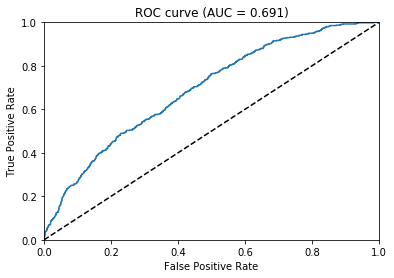

In [13]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [14]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.015998326241970062, recall = 1.0, precision = 0.2736469398077896
Threshold 0.022845137864351273, recall = 0.9981515711645101, precision = 0.27621483375959077
Threshold 0.030424153432250023, recall = 0.9981515711645101, precision = 0.27835051546391754
Threshold 0.047513559460639954, recall = 0.9981515711645101, precision = 0.2806652806652807
Threshold 0.059343356639146805, recall = 0.9981515711645101, precision = 0.2828706128863279
Threshold 0.08773640543222427, recall = 0.9926062846580407, precision = 0.28397673188789
Threshold 0.10349144786596298, recall = 0.9926062846580407, precision = 0.2864
Threshold 0.12835344672203064, recall = 0.9926062846580407, precision = 0.2887096774193548
Threshold 0.15393072366714478, recall = 0.9926062846580407, precision = 0.29121475054229934
Threshold 0.18979483842849731, recall = 0.9907578558225508, precision = 0.29321663019693656
Threshold 0.22343707084655762, recall = 0.9870609981515711, precision = 0.29453943739658023
Threshold 0.244488

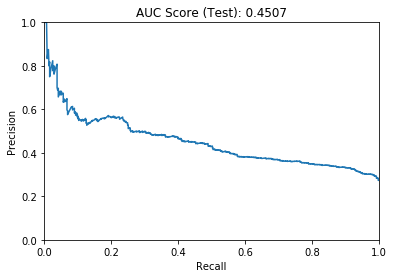

In [15]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 94.5)

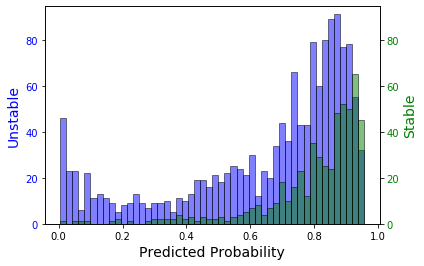

In [18]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,2.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,2.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

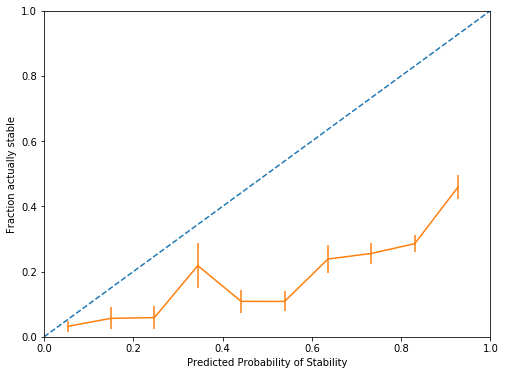

In [19]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

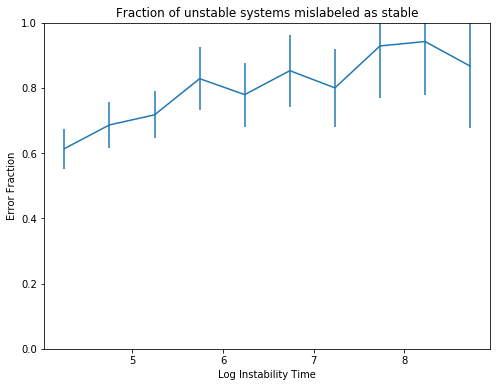

In [20]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

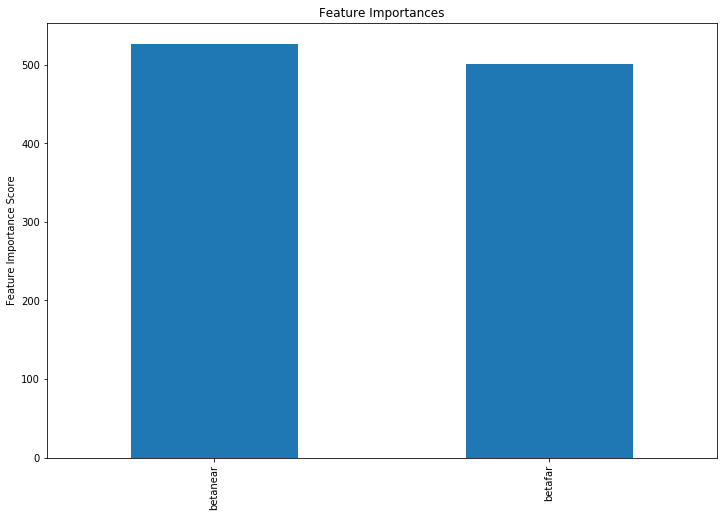

In [21]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [22]:
dill.dump([model, features, featurefolder], open(datapath+"../models/HillSpheresxgb_resonant.pkl", "wb"))